In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.data_util import load_preprocess_examples
from src.data_util import load_augmented_example
from src.evaluation import DAP_SAP_MAP_kde, hist_AP, plot_SAP_MAP

import tensorflow as tf

from sklearn.model_selection import train_test_split
import glob
import json
import os

import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2024-07-30 10:46:50.103212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 10:46:50.899172: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [39]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [40]:
Pigs_all = np.array(["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)])
Pigs_all

array(['P_01_PulHyp', 'P_02_PulHyp', 'P_03_PulHyp', 'P_04_PulHyp',
       'P_05_PulHyp', 'P_06_PulHyp', 'P_07_PulHyp', 'P_08_PulHyp',
       'P_09_PulHyp', 'P_10_PulHyp'], dtype='<U11')

In [41]:
dap_factor = 180
sap_factor = 180
map_factor = 160

**Model**

In [2]:
def AP_model(input_shape, kernel, filters, output_shape=3):
    model_input = tf.keras.layers.Input(shape=input_shape)
    x = model_input

    for fltr in filters:
        x = tf.keras.layers.Conv2D(filters=fltr, kernel_size=kernel, activation="relu")(
            x
        )
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    model_output = tf.keras.layers.Dense(output_shape)(x)

    return tf.keras.models.Model(model_input, model_output)

**Create cross validation instance**

In [43]:
version = "v2"

cross_val_path = "models/cross_validation_12/"

try:
    os.mkdir(cross_val_path)
except:
    print("Exists")

Exists


In [4]:
# Parameters from best HPT
# | model 40: epochs = 50, batch_size = 64, kernels = 9, filters = [8, 4, 2], opt = adam, loss = mse| <-


# cross_validation_1 : PulHypStudie_Check_npz_SNR20
# cross_validation_2 : PulHypStudie_Check_npz_SNR30
# cross_validation_3 : PulHypStudie_Check_npz_v2_SNR30
# cross_validation_4 : PulHypStudie_Check_npz_v2_SNR40
# cross_validation_5 : PulHypStudie_Check_npz_v2_SNR40 ->mae
# cross_validation_6 : PulHypStudie_Check_npz_v2_SNR30 ->mae
# cross_validation_7 : PulHypStudie_Check_npz_v2_SNR10 ->mse

# cross_validation_8 :PulHypStudie_Check_npz_v2_SNR40-
# cross_validation_9 :PulHypStudie_Check_npz_v2_SNR40->mae,bs=16,e=60
# cross_validation_10 :PulHypStudie_Check_npz_v2_SNR30->mae,bs=16,e=60
# cross_validation_11 :PulHypStudie_Check_npz_v2_SNR10->mse,bs=16,e=60

# cross_validation_12 :PulHypStudie_Check_npz_v2_SNR10->mae,bs=16,e=70
# cross_validation_13 :PulHypStudie_Check_npz_v2_SNR20->mae,bs=16,e=70
# cross_validation_14 :PulHypStudie_Check_npz_v2_SNR30->mae,bs=16,e=70
# cross_validation_15 :PulHypStudie_Check_npz_v2_SNR40->mae,bs=16,e=70

load_path = "/data/PulHypStudie_Check_npz_v2_SNR10/"

optimizer = "adam"
loss_fct = "mae"
kernels = 9
filters = [8, 4, 2]
batch_size = 16
epochs = 70

In [45]:
# update depending on the dataset
if version == "v1":
    test_samples_skip = {
        "P_01_PulHyp": 10280,
        "P_02_PulHyp": 12839,
        "P_03_PulHyp": 8127,
        "P_04_PulHyp": 8888,
        "P_05_PulHyp": 9990,
        "P_06_PulHyp": 6915,
        "P_07_PulHyp": 5478,
        "P_08_PulHyp": 7189,
        "P_09_PulHyp": 8226,
        "P_10_PulHyp": 6594,
    }
if version == "v2":
    test_samples_skip = {
        "P_01_PulHyp": 10338,
        "P_02_PulHyp": 12859,
        "P_03_PulHyp": 8124,
        "P_04_PulHyp": 8914,
        "P_05_PulHyp": 10063,
        "P_06_PulHyp": 6934,
        "P_07_PulHyp": 5692,
        "P_08_PulHyp": 7189,
        "P_09_PulHyp": 8228,
        "P_10_PulHyp": 6552,
    }

In [ ]:
for drop_idx, test_pig in enumerate(Pigs_all):
    train_select = [p for p in range(len(Pigs_all)) if p != drop_idx]
    train_pig = Pigs_all[train_select]
    print(f"{train_pig=}\n{test_pig=}\n")

    # load data
    X, y, clrs_pig = load_augmented_example(load_path, train_pig)
    X_train, X_valid, y_train, y_valid, clrs_train, clrs_valid = train_test_split(
        X, y, clrs_pig, test_size=0.1, random_state=42, shuffle=True
    )

    X_test, y_true, clrs_pig_test = load_augmented_example(
        load_path,
        [test_pig],
        sample_skip=test_samples_skip[test_pig],
        load_samples="downwards",
    )
    print(f"{X_test.shape=}, {y_true.shape=}")

    # create model
    model = AP_model(input_shape=(64, 1024, 1), kernel=kernels, filters=filters)
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=["accuracy"])
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
    )

    # predict test pig
    y_pred = model.predict(X_test)
    y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
    y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
    y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization
    # true data values
    # y_true = np.zeros(y_true.shape) # -> overwrite with right value scaling
    y_true[:, 0] = y_true[:, 0] * dap_factor  # dap normalization
    y_true[:, 1] = y_true[:, 1] * sap_factor  # sap normalization
    y_true[:, 2] = y_true[:, 2] * map_factor  # map normalization

    np.savez(
        f"{cross_val_path}/model_history_{test_pig}.npz",
        accuracy=history.history["accuracy"],
        loss=history.history["loss"],
        val_accuracy=history.history["val_accuracy"],
        val_loss=history.history["val_loss"],
    )

    test_loss, test_acc = model.evaluate(X_test, y_pred, verbose=2)

    accs_dct = {
        "model": test_pig,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }

    lst_sqrs = ["DAP_m", "DAP_n", "SAP_m", "SAP_n", "MAP_m", "MAP_n"]
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    ax[0].set_ylabel("Model (mmHg)")
    for ap in range(y_pred.shape[1]):
        y = y_true[:, ap]
        x = y_pred[:, ap]
        A = np.vstack([y, np.ones(len(y))]).T
        m, n = np.linalg.lstsq(A, x, rcond=None)[0]

        accs_dct[lst_sqrs[ap * 2]] = m
        accs_dct[lst_sqrs[ap * 2 + 1]] = n

        x_f = np.linspace(0, 200)
        ax[ap].set_xlabel("Gold Standard (mmHg)")
        ax[ap].set_xlim(0, 200)
        ax[ap].set_ylim(0, 200)
        ax[ap].set_title(lst_sqrs[ap * 2][:3] + test_pig)
        ax[ap].plot(y, x, "o", label="Original data", markersize=1)
        ax[ap].plot(x_f, m * x_f + n, "r", label="Fitted line")
    plt.legend()
    plt.show()

    with open(f"{cross_val_path}/acc_{test_pig}.json", "w") as json_file:
        json.dump(accs_dct, json_file)

    DAP_SAP_MAP_kde(y_pred, y_true, sname=f"{cross_val_path}/AP_kde_{test_pig}.pdf")

    df_SAP = hist_AP(y_pred, y_true, AP="SAP")
    df_MAP = hist_AP(y_pred, y_true, AP="MAP")

    plot_SAP_MAP(df_SAP, df_MAP, sname=f"{cross_val_path}/hist{test_pig}.pdf")
    df_SAP.to_csv(f"{cross_val_path}/df_SAP_{test_pig}.csv", index=False)
    df_MAP.to_csv(f"{cross_val_path}/df_MAP_{test_pig}.csv", index=False)

    acc_measure = dict(Model=list(), Error_val=list(), Error=list())

    data_append = list()
    Errors_names = ["DAP", "SAP", "MAP"]

    for pred, true in zip(y_pred, y_true):
        err = pred - true
        for e in range(3):
            data_append.append(
                dict(Model=drop_idx, Error_val=err[e], Error=Errors_names[e])
            )
    for item in data_append:
        for key, value in item.items():
            acc_measure[key].append(value)

    acc_measure_df = pd.DataFrame(acc_measure).dropna()
    acc_measure_df.to_csv(f"{cross_val_path}/sgl_box_m_{test_pig}.csv", index=False)

train_pig=array(['P_02_PulHyp', 'P_03_PulHyp', 'P_04_PulHyp', 'P_05_PulHyp',
       'P_06_PulHyp', 'P_07_PulHyp', 'P_08_PulHyp', 'P_09_PulHyp',
       'P_10_PulHyp'], dtype='<U11')
test_pig='P_01_PulHyp'

Selected 10338 from /data/PulHypStudie_Check_npz_v2_SNR10/P_01_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v2_SNR10/P_01_PulHyp/sample_010337.npz from pig P_01_PulHyp.
X_test.shape=(10338, 64, 1024, 1), y_true.shape=(10338, 3)
Epoch 1/70
7594/7594 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.6029 - loss: 0.0914 - val_accuracy: 0.8109 - val_loss: 0.0352
Epoch 2/70
7594/7594 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.8268 - loss: 0.0245 - val_accuracy: 0.8507 - val_loss: 0.0196
Epoch 3/70
7594/7594 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.8664 - loss: 0.0175 - val_accuracy: 0.8838 - val_loss: 0.0151
Epoch 4/70
7594/7594 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.8861 - loss: 0.0146 - val_accuracy: 0.9033 - val_loss: 0.0131
Epoch 5/70
7594/7594 ━━━━━━━━━━

## Create KDE and hist for full cross-validation

In [47]:
combined_df_sgl_box = pd.concat(
    [pd.read_csv(f_csvs) for f_csvs in glob.glob(f"{cross_val_path}sgl_box_m*.csv")],
    ignore_index=True,
)
combined_df_sgl_box = pd.DataFrame(combined_df_sgl_box)

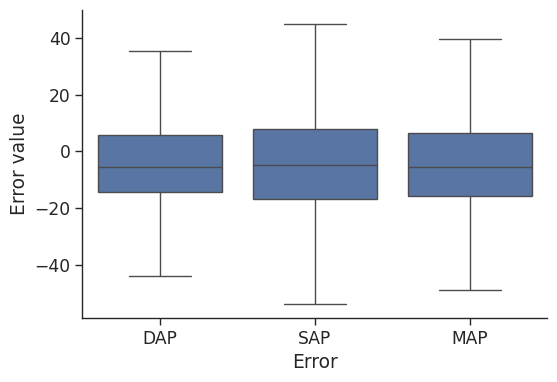

In [48]:
plt.figure(figsize=(6, 4))
sns.boxplot(y="Error_val", x="Error", data=combined_df_sgl_box, showfliers=False)
plt.ylabel("Error value")
plt.show()

In [49]:
combined_df_df_MAP = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/cross_validation_12/df_MAP*.csv")
    ],
    ignore_index=True,
)
combined_df_df_MAP = pd.DataFrame(combined_df_df_MAP)

combined_df_df_SAP = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/cross_validation_12/df_SAP*.csv")
    ],
    ignore_index=True,
)
combined_df_df_SAP = pd.DataFrame(combined_df_df_SAP)

In [50]:
cmbnd_dct_MAP = dict()
for row in combined_df_df_MAP.itertuples(index=True, name="Pandas"):
    if row.Category not in cmbnd_dct_MAP:
        cmbnd_dct_MAP[row.Category] = 0
    cmbnd_dct_MAP[row.Category] += row.Count
cmbnd_dct_MAP = pd.DataFrame.from_dict(cmbnd_dct_MAP, orient="index", columns=["Count"])
cmbnd_dct_MAP.reset_index(inplace=True)
cmbnd_dct_MAP.rename(columns={"index": "Category"}, inplace=True)

cmbnd_dct_SAP = dict()
for row in combined_df_df_SAP.itertuples(index=True, name="Pandas"):
    if row.Category not in cmbnd_dct_SAP:
        cmbnd_dct_SAP[row.Category] = 0
    cmbnd_dct_SAP[row.Category] += row.Count
cmbnd_dct_SAP = pd.DataFrame.from_dict(cmbnd_dct_SAP, orient="index", columns=["Count"])
cmbnd_dct_SAP.reset_index(inplace=True)
cmbnd_dct_SAP.rename(columns={"index": "Category"}, inplace=True)

Cross Validation results


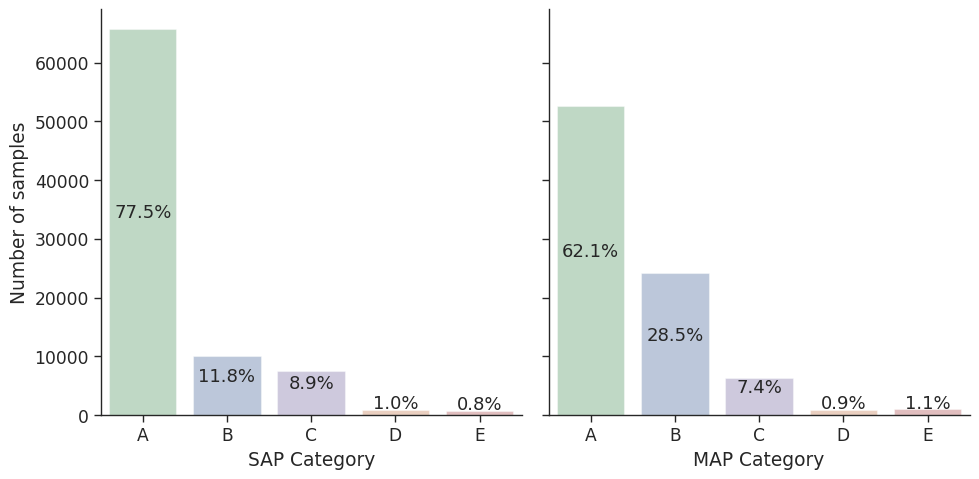

In [51]:
print("Cross Validation results")
plot_SAP_MAP(
    cmbnd_dct_SAP, cmbnd_dct_MAP, sname="images/cross_valid_12_sap_map_all.png"
)

In [52]:
combined_df_sgl_box = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/cross_validation_12/sgl_box_m*.csv")
    ],
    ignore_index=True,
)
combined_df_sgl_box = pd.DataFrame(combined_df_sgl_box)

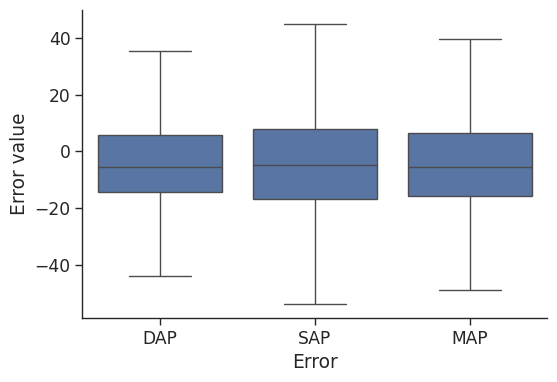

In [53]:
plt.figure(figsize=(6, 4))
sns.boxplot(y="Error_val", x="Error", data=combined_df_sgl_box, showfliers=False)
plt.ylabel("Error value")
plt.show()

In [15]:
combined_df_df_MAP = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/cross_validation_2/df_MAP*.csv")
    ],
    ignore_index=True,
)
combined_df_df_MAP = pd.DataFrame(combined_df_df_MAP)

combined_df_df_SAP = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/cross_validation_2/df_SAP*.csv")
    ],
    ignore_index=True,
)
combined_df_df_SAP = pd.DataFrame(combined_df_df_SAP)

In [16]:
cmbnd_dct_MAP = dict()
for row in combined_df_df_MAP.itertuples(index=True, name="Pandas"):
    if row.Category not in cmbnd_dct_MAP:
        cmbnd_dct_MAP[row.Category] = 0
    cmbnd_dct_MAP[row.Category] += row.Count
cmbnd_dct_MAP = pd.DataFrame.from_dict(cmbnd_dct_MAP, orient="index", columns=["Count"])
cmbnd_dct_MAP.reset_index(inplace=True)
cmbnd_dct_MAP.rename(columns={"index": "Category"}, inplace=True)

cmbnd_dct_SAP = dict()
for row in combined_df_df_SAP.itertuples(index=True, name="Pandas"):
    if row.Category not in cmbnd_dct_SAP:
        cmbnd_dct_SAP[row.Category] = 0
    cmbnd_dct_SAP[row.Category] += row.Count
cmbnd_dct_SAP = pd.DataFrame.from_dict(cmbnd_dct_SAP, orient="index", columns=["Count"])
cmbnd_dct_SAP.reset_index(inplace=True)
cmbnd_dct_SAP.rename(columns={"index": "Category"}, inplace=True)

Cross Validation results


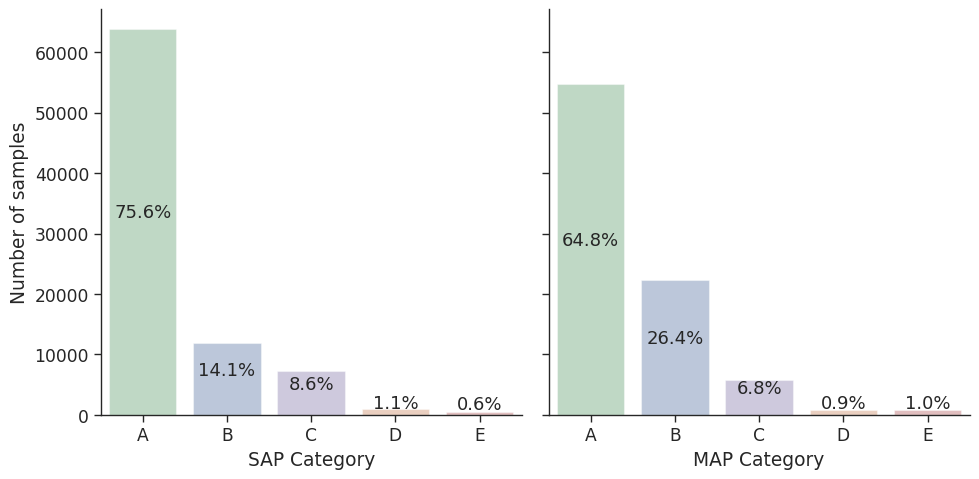

In [18]:
print("Cross Validation results")
plot_SAP_MAP(cmbnd_dct_SAP, cmbnd_dct_MAP, sname="images/cross_valid_2_sap_map_all.png")

In [12]:
combined_df_sgl_box = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/cross_validation_4/sgl_box_m*.csv")
    ],
    ignore_index=True,
)
combined_df_sgl_box = pd.DataFrame(combined_df_sgl_box)

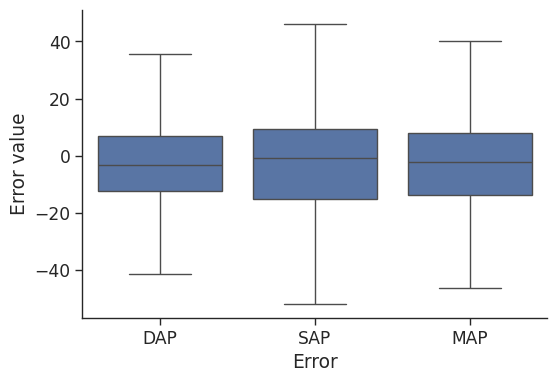

In [13]:
plt.figure(figsize=(6, 4))
sns.boxplot(y="Error_val", x="Error", data=combined_df_sgl_box, showfliers=False)
plt.ylabel("Error value")
plt.show()

In [26]:
combined_df_df_MAP = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/cross_validation_8/df_MAP*.csv")
    ],
    ignore_index=True,
)
combined_df_df_MAP = pd.DataFrame(combined_df_df_MAP)

combined_df_df_SAP = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/cross_validation_8/df_SAP*.csv")
    ],
    ignore_index=True,
)
combined_df_df_SAP = pd.DataFrame(combined_df_df_SAP)

In [27]:
cmbnd_dct_MAP = dict()
for row in combined_df_df_MAP.itertuples(index=True, name="Pandas"):
    if row.Category not in cmbnd_dct_MAP:
        cmbnd_dct_MAP[row.Category] = 0
    cmbnd_dct_MAP[row.Category] += row.Count
cmbnd_dct_MAP = pd.DataFrame.from_dict(cmbnd_dct_MAP, orient="index", columns=["Count"])
cmbnd_dct_MAP.reset_index(inplace=True)
cmbnd_dct_MAP.rename(columns={"index": "Category"}, inplace=True)

cmbnd_dct_SAP = dict()
for row in combined_df_df_SAP.itertuples(index=True, name="Pandas"):
    if row.Category not in cmbnd_dct_SAP:
        cmbnd_dct_SAP[row.Category] = 0
    cmbnd_dct_SAP[row.Category] += row.Count
cmbnd_dct_SAP = pd.DataFrame.from_dict(cmbnd_dct_SAP, orient="index", columns=["Count"])
cmbnd_dct_SAP.reset_index(inplace=True)
cmbnd_dct_SAP.rename(columns={"index": "Category"}, inplace=True)

Cross Validation results


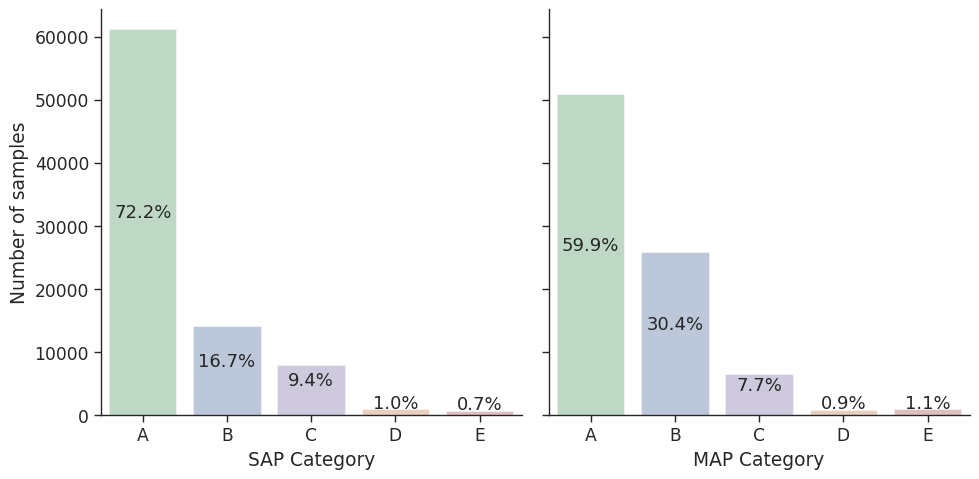

In [28]:
print("Cross Validation results")
plot_SAP_MAP(cmbnd_dct_SAP, cmbnd_dct_MAP, sname="images/cross_valid_8_sap_map_all.png")